# NARPS Parametric design - 2nd level analysis

Parametric effect of gain:
1. Positive effect in ventromedial PFC - for the equal indifference group
2. Positive effect in ventromedial PFC - for the equal range group
3. Positive effect in ventral striatum - for the equal indifference group
4. Positive effect in ventral striatum - for the equal range group

Parametric effect of loss:
5. Negative effect in VMPFC - for the equal indifference group
6. Negative effect in VMPFC - for the equal range group
7. Positive effect in amygdala - for the equal indifference group
8. Positive effect in amygdala - for the equal range group

Equal range vs. equal indifference:
9. Greater positive response to losses in amygdala for equal range condition vs. equal
indifference condition.

Other info:
N = 108 (equal indifference group (n = 54), equal range group (n = 54))

In [1]:
%matplotlib inline

In [2]:
import socket
import random
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
import nistats
from nilearn import plotting
from nistats.second_level_model import SecondLevelModel
import matplotlib.pyplot as plt
from nistats.reporting import plot_design_matrix
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_glass_brain
from nistats.thresholding import map_threshold

/home/lmn/install/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/lmn/install/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
myhost = socket.gethostname()
if myhost == 'lmn-pc':
    root = '/media/lmn/86A406A0A406933B5/narps'

print(root)

/media/lmn/86A406A0A406933B5/narps


In [4]:
# make 2nd level folder
#if not os.path.exists(root + '/derivatives/nistats/2ndlevel'):
   # os.makedirs(root + '/derivatives/nistats/2nd_level')
    
# Path for saving the maps
savepath = root + '/derivatives/nistats/2nd_level/'

In [5]:
# 1st level path
first_level_path = root + '/derivatives/nistats/1st_level/'

# Load subject identifiers
subject_ids = [s[-7:] for s in sorted(glob(first_level_path + 'sub-*'))]
len(subject_ids)

108

In [6]:
# Load participants file
parti_file = root + '/event_tsvs/participants.tsv'
parti = pd.read_csv(parti_file, sep='\t')
subject_selecter = [p in subject_ids for p in parti['participant_id']]
parti = parti[subject_selecter]
len(parti)

# Different groups
grp_eI = parti.loc[parti['group'] == 'equalIndifference']
grp_eR = parti.loc[parti['group'] == 'equalRange']

grp_eI_ind = np.ndarray.tolist(grp_eI.index.get_values())
grp_eR_ind = np.ndarray.tolist(grp_eR.index.get_values())

In [7]:
# some parameters
nr_sub = int(len(subject_ids))
print('Nr of subjects:', nr_sub)
cond = ['Accept', 'Reject']
nr_cond = len(cond)
print('Experimental conditions:',['Accept','Reject'] )
nr_groups = parti['group'].nunique()
groups = parti['group'].unique()
print('Experimental Groups:', parti['group'].unique())

bg_img = root + '/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz'

Nr of subjects: 108
Experimental conditions: ['Accept', 'Reject']
Experimental Groups: ['equalIndifference' 'equalRange']


In [8]:
# subject 1st level maps
# Accept or Gain
acc = [first_level_path + '{0}/{0}_zmap_Accept_norm.nii.gz'.format(s, s)
             for s in subject_ids]

# Reject or Loss
rej = [first_level_path + '{0}/{0}_zmap_Reject_norm.nii.gz'.format(s, s)
             for s in subject_ids]

# accept vs Reject or Gain vs Loss
aVSr = [first_level_path + '{0}/{0}_zmap_AcceptVsReject_norm.nii.gz'.format(s, s)
             for s in subject_ids]

In [9]:
# maps for different groups
# Gain maps
acc_eI = [acc[i] for i in grp_eI_ind] 
acc_eR = [acc[i] for i in grp_eR_ind] 

# Loss maps
rej_eI = [rej[i] for i in grp_eI_ind] 
rej_eR = [rej[i] for i in grp_eR_ind] 

# Gain vs Loss maps
aVSr_eI = [aVSr[i] for i in grp_eI_ind] 
aVSr_eR = [aVSr[i] for i in grp_eR_ind] 

In [10]:
# Load Neurosynth ROIs, resmaple to 1 mm iso, binarize at a certain threshold and save out
from nilearn.image import resample_to_img
from nibabel import load, save, Nifti1Image
lthr = [13.97, 13.86, 8.17]

ns_ROIs = sorted(glob(root + '/neurosynth_ROIs/ROI_*_0.01.nii.gz'))

for i, stat_img in enumerate(ns_ROIs):
    print(i, stat_img)
    resampled_stat_img = resample_to_img(stat_img, bg_img, interpolation='nearest')
    data = resampled_stat_img.get_data()
    bin_data = np.where(data > lthr[i], 1, 0) 
    
    out = Nifti1Image(bin_data, header=resampled_stat_img.header, affine=resampled_stat_img.affine)
    save(out, stat_img[:-6] + 'rsmpld_thr.nii.gz' )

0 /media/lmn/86A406A0A406933B5/narps/neurosynth_ROIs/ROI_amygdala_association-test_z_FDR_0.01.nii.gz
1 /media/lmn/86A406A0A406933B5/narps/neurosynth_ROIs/ROI_ventral_striatum_association-test_z_FDR_0.01.nii.gz
2 /media/lmn/86A406A0A406933B5/narps/neurosynth_ROIs/ROI_ventromedial_prefrontal_association-test_z_FDR_0.01.nii.gz


In [11]:
ns_labels = sorted(glob(root + '/neurosynth_ROIs/ROI_*thr*nii.gz'))
ns_dict = {'amygdala': ns_labels[0], 'striatum': ns_labels[1], 'VMPFC':ns_labels[2]}

In [12]:
for n in ns_dict:
    plot_glass_brain(
        ns_dict[n], plot_abs=True, symmetric_cbar=True,
        black_bg=True, display_mode='lyrz', title='ROI {}'.format(n),
        output_file= savepath + 'roi_' + n + '.png')

/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# 2nd Level model

One sample t-tests in each groups' simple contrasts (Accept, Reject)


## Parametric effect of gain for the equal indifference group

In [13]:
name = cond[0] + '_' + groups[0] 
second_level_input = acc_eI
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

# estimate the contrast
z_map_01 = second_level_model.compute_contrast(output_type='z_score')
save_name = savepath + 'zmap_' + name + '.nii.gz'
z_map_01.to_filename(save_name)

for h, thr in [['fpr', 0.001],
               ['fdr', 0.05],
               ['bonferroni', 0.05]]:
    _, threshold = map_threshold(z_map_01, level=thr, height_control=h)

    plot_glass_brain(
        z_map_01, threshold=threshold, plot_abs=False, symmetric_cbar=False,
        black_bg=True, display_mode='lyrz', colorbar=True,
        title='{} ({}: {} - Z > {:.4})'.format(name, h, thr, threshold),
        output_file= savepath + 'glass_' + name + '_' + h + '.png')

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


## Parametric effect of loss for the equal indifference group

In [14]:
name = cond[1] + '_' + groups[0] 
second_level_input = rej_eI
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

# estimate the contrast
z_map_02 = second_level_model.compute_contrast(output_type='z_score')
save_name = savepath + 'zmap_' + name + '.nii.gz'
z_map_02.to_filename(save_name)

for h, thr in [['fpr', 0.001],
               ['fdr', 0.05],
               ['bonferroni', 0.05]]:
    _, threshold = map_threshold(z_map_02, level=thr, height_control=h)

    plot_glass_brain(
        z_map_02, threshold=threshold, plot_abs=False, symmetric_cbar=False,
        black_bg=True, display_mode='lyrz', colorbar=True,
        title='{} ({}: {} - Z > {:.4})'.format(name, h, thr, threshold),
        output_file= savepath + 'glass_' + name + '_' + h + '.png')

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


## Parametric effect of gain for the equal range group

In [15]:
name = cond[0] + '_' + groups[1] 
second_level_input = acc_eR
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

# estimate the contrast
z_map_03 = second_level_model.compute_contrast(output_type='z_score')
save_name = savepath + 'zmap_' + name + '.nii.gz'
z_map_03.to_filename(save_name)

for h, thr in [['fpr', 0.001],
               ['fdr', 0.05],
               ['bonferroni', 0.05]]:
    _, threshold = map_threshold(z_map_03, level=thr, height_control=h)

    plot_glass_brain(
        z_map_03, threshold=threshold, plot_abs=False, symmetric_cbar=False,
        black_bg=True, display_mode='lyrz', colorbar=True,
        title='{} ({}: {} - Z > {:.4})'.format(name, h, thr, threshold),
        output_file= savepath + 'glass_' + name + '_' + h + '.png')

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


## Parametric effect of loss for the equal range group

In [16]:
name = cond[1] + '_' + groups[1] 
second_level_input = rej_eR
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

# estimate the contrast
z_map_04 = second_level_model.compute_contrast(output_type='z_score')
save_name = savepath + 'zmap_' + name + '.nii.gz'
z_map_04.to_filename(save_name)

for h, thr in [['fpr', 0.001],
               ['fdr', 0.05],
               ['bonferroni', 0.05]]:
    _, threshold = map_threshold(z_map_04, level=thr, height_control=h)

    plot_glass_brain(
        z_map_04, threshold=threshold, plot_abs=False, symmetric_cbar=False,
        black_bg=True, display_mode='lyrz', colorbar=True,
        title='{} ({}: {} - Z > {:.4})'.format(name, h, thr, threshold),
        output_file= savepath + 'glass_' + name + '_' + h + '.png')

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# Group Comparison
Equal range vs. equal indifference:
Greater positive response to losses in amygdala for equal range condition vs. equal
indifference condition.

In [17]:
second_level_input = rej
grp_effect = np.zeros((nr_sub, 2))
grp_effect[grp_eR_ind, 0] = 1
grp_effect[grp_eI_ind, 1] = 1

In [18]:
# DM for two-sample t-test
design_matrix = pd.DataFrame(grp_effect, columns=['Equal', 'Indifference'])

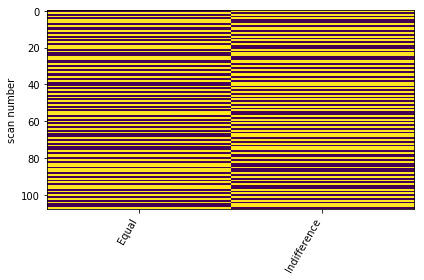

In [19]:
from nistats.reporting import plot_design_matrix

plot_design_matrix(design_matrix)
plt.savefig(savepath + 'group_comparison_dm.png', dpi =300)

In [20]:
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

# estimate the contrast and plot it
z_map_grp = second_level_model.compute_contrast(
    second_level_contrast=[1, -1],
    second_level_stat_type='t',
    output_type='z_score')
save_name = savepath + 'zmap_GroupComparison.nii.gz'
z_map_grp.to_filename(save_name)

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [21]:
for h, thr in [['fpr', 0.001],
               ['fdr', 0.05],
               ['bonferroni', 0.05]]:
    _, threshold = map_threshold(z_map_grp, level=thr, height_control=h)

    plot_glass_brain(
        z_map_grp, threshold=threshold, plot_abs=False, symmetric_cbar=False,
        black_bg=True, display_mode='lyrz', colorbar=True,
        title='{} ({}: {} - Z > {:.4})'.format('Range vs Indifference', h, thr, threshold),
        output_file= savepath + 'glass__Group_Comparison_' + h + '.png')

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
